<a href="https://colab.research.google.com/github/Abd-Alfatah/Abd-Alfatah/blob/main/soc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import random
import math
import mpmath as mp
import torch
import torch.nn as nn
import seaborn as sns

In [64]:
#mount to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
%cd /content/drive/MyDrive/state_of_charge

/content/drive/MyDrive/state_of_charge


In [66]:
soc_para=pd.read_excel('TripA02.xlsx')
# Remove columns with all zero values
soc_para = soc_para.loc[:, (soc_para != 0).any(axis=0)]
print(soc_para.head())

   Velocity [km/h]  Elevation [m]  Throttle [%]  Motor Torque [Nm]  \
0            96.89          589.0         45.50              14.00   
1            96.87          589.0         45.61              15.00   
2            96.81          589.0         45.50              15.32   
3            96.74          589.0         45.50              15.18   
4            96.72          589.0         45.50              15.50   

   Longitudinal Acceleration [m/s^2]  Regenerative Braking Signal   \
0                               0.09                           0.0   
1                               0.11                           0.0   
2                               0.09                           0.0   
3                              -0.01                           0.0   
4                               0.01                           0.0   

   Battery Voltage [V]  Battery Current [A]  Battery Temperature [°C]  \
0               381.80               -37.60                      23.0   
1           

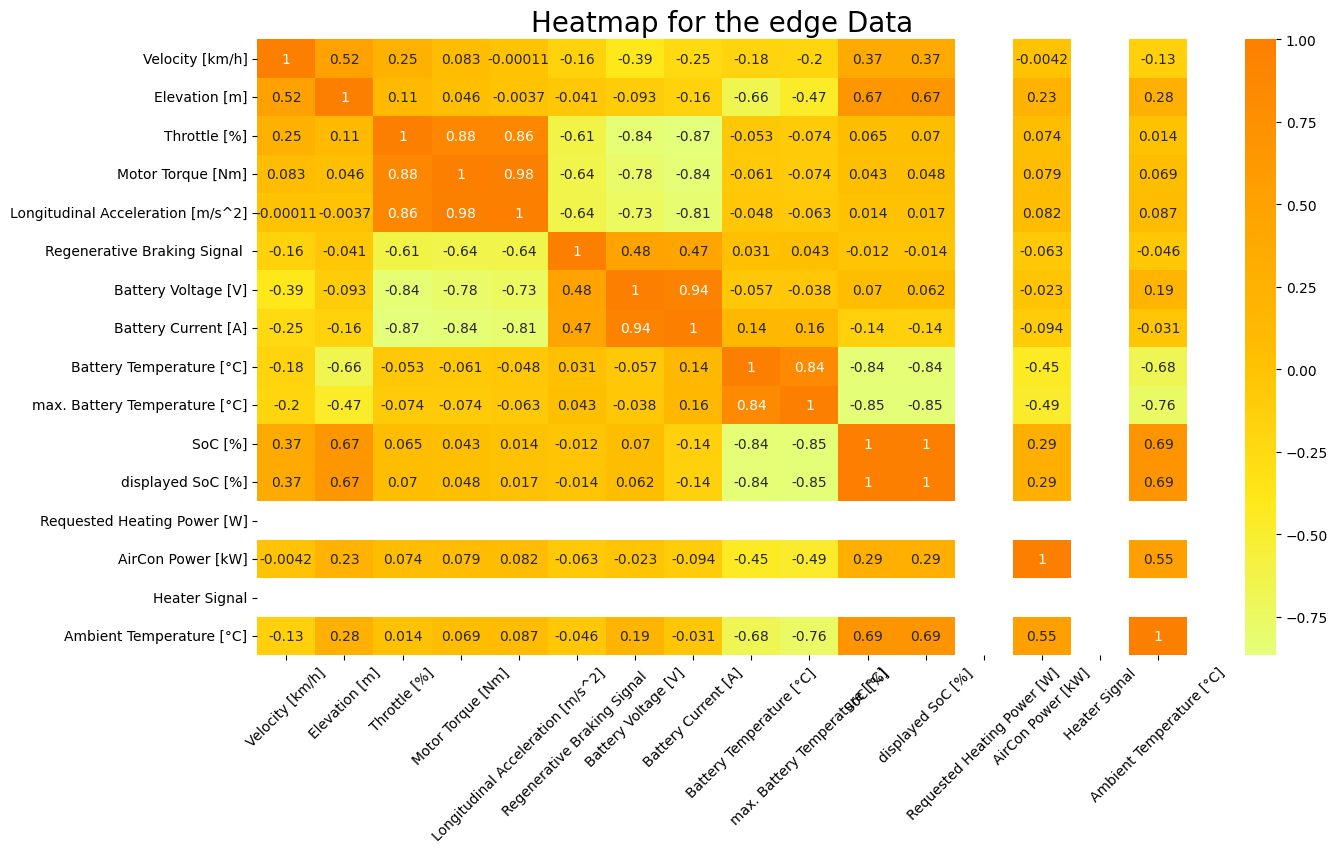

In [67]:
def heatmap(soc_para):
    plt.rcParams['figure.figsize'] = (15, 8)
    sns.heatmap(soc_para.corr(), cmap = 'Wistia', annot = True)
    plt.title('Heatmap for the edge Data', fontsize = 20)
    plt.xticks(rotation=45)
    plt.savefig("heatmap1.png")
heatmap(soc_para)

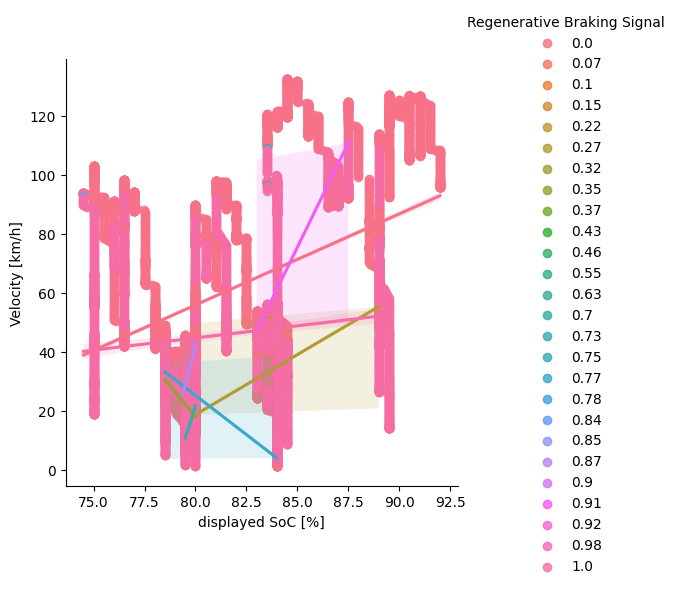

In [68]:
sns.lmplot(x="displayed SoC [%]", y="Velocity [km/h]",hue="Regenerative Braking Signal ",data=soc_para)

In [69]:
# In this module we clean the data, split,plot,and load it.
class dataCleaningandSplitting:
    global minmax
    minmax= list()
    def __init__(self,data) -> None:
        self.data=data
    def dataCleaning(self):
        self.data.info()
    #max and min in the dataset
    def dataset_minmax(self):
        stats=[]
        for column in (self.data.columns):
            stats.append([min(self.data[column]),max(self.data[column])])
        return stats
    # Rescale dataset columns to the range 0-1
    def normalize_dataset(self):
        minmax=self.dataset_minmax()
        #convertinf all the data integers into floats
        for column in self.data.columns:
            self.data[column] = self.data[column].astype(float)
        for x in range(len(self.data)):
            for y in range(len(self.data.columns)):
                self.data.loc[x,self.data.columns[y]] = (self.data.loc[x,self.data.columns[y]] - minmax[y][0]) / (minmax[y][1] - minmax[y][0])
    def trainig_data(self):
        """
        devide the dataset into training and testing parts
        """
        self.normalize_dataset()
        trainingSet=np.matrix(self.data.iloc[:9000,:])
        trainingSet=np.asfarray(trainingSet, int)
        return  trainingSet
    def testing_data(self):
        self.normalize_dataset()
        testingSet=np.matrix(self.data.iloc[9000:,:])
        testingSet=np.asfarray(testingSet, int)
        return testingSet

    def testing(self):
        self.normalize_dataset()
        testingSet=np.matrix(self.data)
        testingSet=np.asfarray(testingSet, int)
        return testingSet

In [70]:
class Backpropagation:
    def initialize(self, nInputs, nHidden, nOutputs):
        network = list()
        hiddenLayer = [{'weights': [random() for i in range(nInputs + 1)]} for i in range(nHidden)]
        network.append(hiddenLayer)
        outputLayer = [{'weights': [random() for i in range(nHidden + 1)]} for i in range(nOutputs)]
        network.append(outputLayer)
        return network

    # Propagate forward
    def activate(self, inputs, weights):
        activation = weights[-1]
        for i in range(len(weights) - 1):
            activation += weights[i] * inputs[i]
        return activation

    def transfer(self, activation):
      #
        return np.tanh(activation)#return 1.0 / (1.0 + math.exp(-activation))#np.log(1.0+np.exp(activation))#np.exp(activation) / np.sum(np.exp(activation))

    def forwardPropagate(self, network, row):
        inputs = row
        for layer in network:
            newInputs = []
            for neuron in layer:
                activation = self.activate(inputs, neuron['weights'])
                neuron['output'] = self.transfer(activation)
                newInputs.append(neuron['output'])
            inputs = newInputs
        return inputs

    # Propagate backwards
    def transferDerivative(self, output):
        ##
        return 1-output**2##return output * (1.0 - output)#(np.exp(output)-1)/(np.exp(output))#1/(1+mp.exp(-activation))#

    def backwardPropagateError(self, network, expected):
        for i in reversed(range(len(network))):
            layer = network[i]
            errors = list()
            if (i != len(network) - 1):
                for j in range(len(layer)):
                    error = 0.0
                    for neuron in network[i + 1]:
                        error += (neuron['weights'][j] * neuron['delta'])
                    errors.append(error)
            else:
                for j in range(len(layer)):
                    neuron = layer[j]
                    errors.append(expected[j] - neuron['output'])
            for j in range(len(layer)):
                neuron = layer[j]
                neuron['delta'] = errors[j] * self.transferDerivative(neuron['output'])

    # For train network
    def updateWeights(self, network, row, learningRate, nOutputs):
        nOutputs = nOutputs * -1
        for i in range(len(network)):
            inputs = row[:nOutputs]
            if (i != 0):
                inputs = [neuron['output'] for neuron in network[i - 1]]
            for neuron in network[i]:
                for j in range(len(network[i])):
                    neuron['weights'][j] += learningRate * neuron['delta'] * inputs[j]
                neuron['weights'][-1] += learningRate * neuron['delta']

    def updateLearningRate(self, learningRate, decay, epoch):
        return learningRate * 1 / (1 + decay * epoch)

    def trainingNetwork(self, network, train, learningRate, nEpochs, nOutputs, expectedError):
        sumError = 10000.0
        for epoch in range(nEpochs):
            if (sumError <= expectedError):
                break
            if(epoch % 50 == 0):
                learningRate = self.updateLearningRate(learningRate, learningRate/nEpochs, float(epoch))

            sumError = 0
            for row in train:
                outputs = self.forwardPropagate(network, row)
                expected = self.getExpected(row, nOutputs)
                sumError += sum([(expected[i] - outputs[i]) ** 2 for i in range(len(expected))])
                self.backwardPropagateError(network, expected)
                self.updateWeights(network, row, learningRate, nOutputs)
            print('> epoch=%d, lrate=%.3f, error=%.3f' % (epoch, learningRate, sumError))

    def getExpected(self, row, nOutputs):
        expected = []
        for i in range(nOutputs):
            temp = (nOutputs - i) * - 1
            expected.append(row[temp])
        return expected
    # For predict result
    def predict(self, network, row):
        outputs = self.forwardPropagate(network, row)
        return outputs
    def predictY1(self, network, row):
        outputs = self.forwardPropagate(network, row)
        return outputs
    # For predict result
    def predictY2(self, network, row):
        outputs = self.forwardPropagate(network, row)
        return outputs[1]

In [71]:
soc_para = soc_para[[col for col in soc_para.columns if col not in ['SoC [%]', 'displayed SoC [%]']] + ['SoC [%]', 'displayed SoC [%]']]
soc_para = soc_para[[col for col in soc_para.columns if col not in ['Heater Signal', 'Requested Heating Power [W]']]]
load_data=dataCleaningandSplitting(soc_para)
load_data.dataCleaning()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14130 entries, 0 to 14129
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Velocity [km/h]                    14130 non-null  float64
 1   Elevation [m]                      14130 non-null  float64
 2   Throttle [%]                       14130 non-null  float64
 3   Motor Torque [Nm]                  14130 non-null  float64
 4   Longitudinal Acceleration [m/s^2]  14130 non-null  float64
 5   Regenerative Braking Signal        14130 non-null  float64
 6   Battery Voltage [V]                14130 non-null  float64
 7   Battery Current [A]                14130 non-null  float64
 8   Battery Temperature [°C]           14130 non-null  float64
 9   max. Battery Temperature [°C]      14130 non-null  float64
 10  AirCon Power [kW]                  14130 non-null  float64
 11  Ambient Temperature [°C]           14130 non-null  flo

In [72]:
soc_para= soc_para.dropna()
load_data.dataset_minmax()
load_data.normalize_dataset()
load_data.testing_data()
load_data.trainig_data()

array([[0.72786686, 1.        , 0.50544323, ..., 0.83333333, 1.        ,
        1.        ],
       [0.72771487, 1.        , 0.50666519, ..., 0.83333333, 1.        ,
        1.        ],
       [0.72725891, 1.        , 0.50544323, ..., 0.83333333, 1.        ,
        1.        ],
       ...,
       [0.18778023, 0.26      , 0.29360142, ..., 0.66666667, 0.29104478,
        0.28571429],
       [0.18542442, 0.26      , 0.29526772, ..., 0.66666667, 0.29104478,
        0.28571429],
       [0.18291664, 0.26      , 0.29526772, ..., 0.66666667, 0.29104478,
        0.28571429]])

In [62]:
#back propagation
nOutputs =int(input('Insert the number Neurons into Output Layer: '))
nEpochs = int(input('Insert the number of Epochs: '))
nHiddenLayer =int(input('Insert the number Neurons into Hidden Layer: '))
learningRate = float(input('Insert Learning Rate: '))
expectedError = float(input('Insert Expected Error: '))

Insert the number Neurons into Output Layer: 2
Insert the number of Epochs: 250
Insert the number Neurons into Hidden Layer: 11
Insert Learning Rate: 0.15
Insert Expected Error: 0.1


In [73]:
print(soc_para.head())

   Velocity [km/h]  Elevation [m]  Throttle [%]  Motor Torque [Nm]  \
0            96.89          589.0         45.50              14.00   
1            96.87          589.0         45.61              15.00   
2            96.81          589.0         45.50              15.32   
3            96.74          589.0         45.50              15.18   
4            96.72          589.0         45.50              15.50   

   Longitudinal Acceleration [m/s^2]  Regenerative Braking Signal   \
0                               0.09                           0.0   
1                               0.11                           0.0   
2                               0.09                           0.0   
3                              -0.01                           0.0   
4                               0.01                           0.0   

   Battery Voltage [V]  Battery Current [A]  Battery Temperature [°C]  \
0               381.80               -37.60                      23.0   
1           

In [74]:
backpropagation = Backpropagation()
nInputs = len(dataCleaningandSplitting(soc_para).trainig_data()[0]) - nOutputs
network = backpropagation.initialize(nInputs, nHiddenLayer, nOutputs)
#backpropagation.forwardPropagate(network,nInputs)
backpropagation.trainingNetwork(network, dataCleaningandSplitting(soc_para).trainig_data(), learningRate, nEpochs, nOutputs, expectedError)
def writeWieghtsToFile(network):
    my_df = pd.DataFrame(network)
    my_df.to_csv('my_array.csv',header = False, index= False)
writeWieghtsToFile(network)
input('\nPress enter to view Result...')

> epoch=0, lrate=0.150, error=4216.704
> epoch=1, lrate=0.150, error=4216.700
> epoch=2, lrate=0.150, error=4216.696
> epoch=3, lrate=0.150, error=4216.692
> epoch=4, lrate=0.150, error=4216.687
> epoch=5, lrate=0.150, error=4216.682
> epoch=6, lrate=0.150, error=4216.676
> epoch=7, lrate=0.150, error=4216.669
> epoch=8, lrate=0.150, error=4216.662
> epoch=9, lrate=0.150, error=4216.654
> epoch=10, lrate=0.150, error=4216.645
> epoch=11, lrate=0.150, error=4216.634
> epoch=12, lrate=0.150, error=4216.622
> epoch=13, lrate=0.150, error=4216.607
> epoch=14, lrate=0.150, error=4216.591
> epoch=15, lrate=0.150, error=4216.570
> epoch=16, lrate=0.150, error=4216.545
> epoch=17, lrate=0.150, error=4216.514
> epoch=18, lrate=0.150, error=4216.474
> epoch=19, lrate=0.150, error=4216.419
> epoch=20, lrate=0.150, error=4216.342
> epoch=21, lrate=0.150, error=4216.222
> epoch=22, lrate=0.150, error=4216.008
> epoch=23, lrate=0.150, error=4215.477
> epoch=24, lrate=0.150, error=3578.533
> epoch=25

''

In [75]:
Y1=list()
Y2=list()
for row in dataCleaningandSplitting(soc_para).testing():
    Y1.append(backpropagation.predictY1(network, row))
    Y2.append(backpropagation.predictY2(network, row))

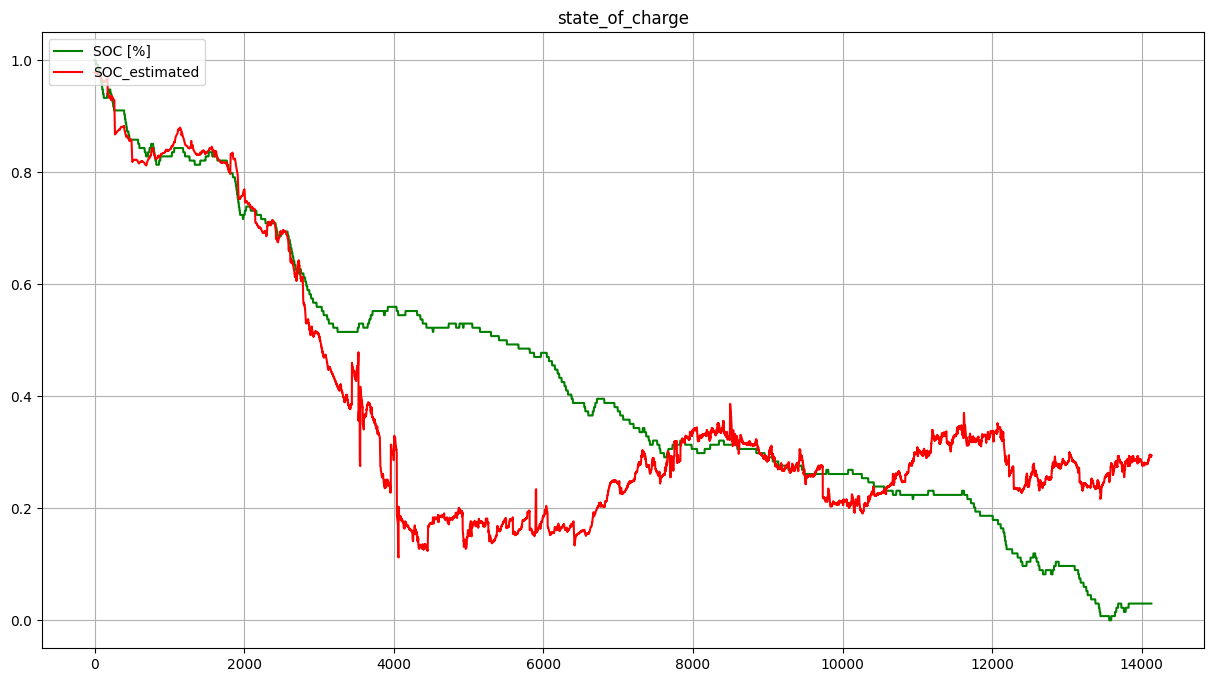

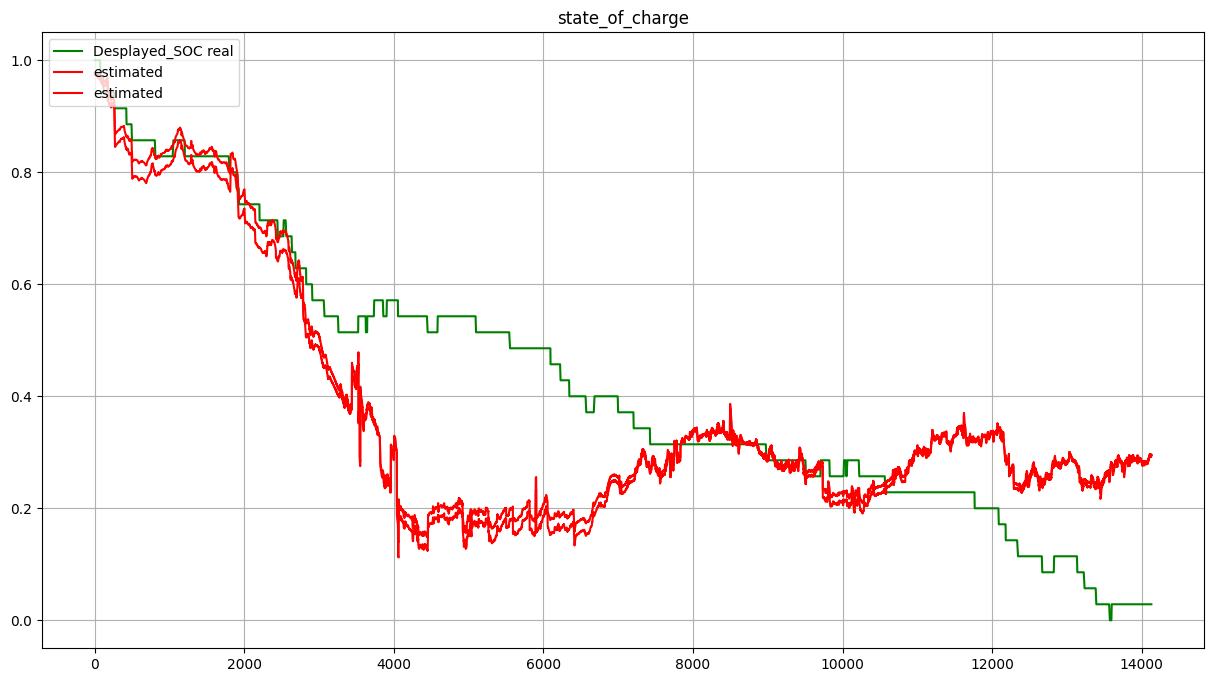

In [76]:
fig, ax = plt.subplots()
plt.title("state_of_charge")
ax.plot(list(soc_para['SoC [%]']), color = 'green', label = 'SOC [%]')
ax.plot(Y2, color = 'red', label = 'SOC_estimated')
ax.legend(loc = 'upper left')
plt.grid()


fig2 , ax2 = plt.subplots()
plt.title("state_of_charge")
ax2.plot(list(soc_para['displayed SoC [%]']), color = 'green', label = 'Desplayed_SOC real')
ax2.plot(Y1, color = 'red', label = 'estimated')
ax2.legend(loc = 'upper left')
plt.grid()
plt.show()

In [77]:
soc_para.tail()

,Velocity [km/h],Elevation [m],Throttle [%],Motor Torque [Nm],Longitudinal Acceleration [m/s^2],Regenerative Braking Signal,Battery Voltage [V],Battery Current [A],Battery Temperature [°C],max. Battery Temperature [°C],AirCon Power [kW],Ambient Temperature [°C],SoC [%],displayed SoC [%]
14125,0.342503,0.325581,0.386248,0.371157,0.635088,0.0,0.647785,0.695223,1.0,1.0,0.296296,0.333333,0.029851,0.028571
14126,0.342351,0.325581,0.382137,0.375706,0.522807,0.0,0.647785,0.694987,1.0,1.0,0.296296,0.333333,0.029851,0.028571
14127,0.342123,0.325581,0.384914,0.371644,0.557895,0.0,0.647785,0.694727,1.0,1.0,0.296296,0.333333,0.029851,0.028571
14128,0.342275,0.325581,0.383693,0.372416,0.573684,0.0,0.647785,0.694374,1.0,1.0,0.296296,0.333333,0.029851,0.028571
14129,0.342427,0.325581,0.384137,0.370385,0.556140,0.0,0.647785,0.694044,1.0,1.0,0.296296,0.333333,0.029851,0.028571
